# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import ast
import dtale

from sklearn import preprocessing as pp
import pickle

from sklearn import model_selection as ms
import category_encoders as ce
# from dataprep.datasets  import load_dataset
# from dataprep.eda       import create_report

#from boruta   import BorutaPy
from lightgbm import LGBMClassifier

from sklearn.ensemble        import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost                 import XGBRegressor
from sklearn.linear_model    import LogisticRegression, SGDRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, BaggingRegressor
from sklearn.metrics         import accuracy_score, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes     import GaussianNB
from lightgbm                import LGBMRegressor

## Helper Functions

In [2]:
def test_preparation(X_test, y_test):
    X_test = rescalling(X_test)
    X_test = transform(X_test)
    y_test = log_var_resposta(y_test)
    
    return X_test, y_test


def rescalling (X_test):
    
    mm = pickle.load(open('parameters/mm_avg_delivery_time_days.pkl','rb'))
    X_test['avg_delivery_time_days'] = mm.transform(X_test[['avg_delivery_time_days']])
    
    rs_ar = pickle.load(open('parameters/rs_average_rating.pkl','rb'))
    
    X_test['average_rating'] = rs_ar.transform(X_test[['average_rating']])
    
    rs_nr = pickle.load(open('parameters/rs_number_of_reviews.pkl','rb'))
    
    X_test['number_of_reviews'] = rs_nr.transform(X_test[['number_of_reviews']])
    
    return X_test

def transform (X_test):
    
    for att in ['brand', 'product', 'seller']:
        fe = pickle.load(open(f'parameters/fe_{att}.pkl', 'rb'))
        X_test = fe.transform(X_test)
    
    return X_test

def log_var_resposta(df):
    df = np.log1p(df)
    return df

def feature_selection(df):
    features_selected = [
    'average_rating',
    'number_of_reviews',
    'brand',
    # 'category',
    # 'crawled_at',
    'out_of_stock',
    'avg_delivery_time_days',
    # 'product_details',
    'seller',
    # 'sub_category',
    # 'fabrication_time',
    # 'title',
    'product'
    ]
    
    return df[features_selected]


# Load Data

In [3]:
# Opening JSON file
train = open('dataset/raw/train.json')
 
# returns JSON object as 
# a dictionary
data_train_aux = json.load(train)

data_train = pd.json_normalize(data_train_aux, record_path = 'data')
data_train.columns = data_train_aux['columns']
data_train.head()

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title,actual_price
0,53df9662-e500-569c-946e-0c8d215a72cd,3.2,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cott...",ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.0
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.0,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.0
2,79c8f0d7-30b1-5dd4-9f2f-2fe97782b027,3.9,32,Free Authori,Clothing and Accessories,2021-02-11 00:43:37,Free Authority Presents this Crew Neck Yellow ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,SWSFWCXH2WF6ZYRB,"[{'Color': 'Yellow'}, {'Fabric': 'Polycotton'}...",BioworldMerchandising,Winter Wear,53,Full Sleeve Graphic Print Men Sweatshirt,1499.0
3,0531c28c-7c50-5fbd-9ce3-a7cae3243ad5,3.8,31,HUMBE,Clothing and Accessories,2021-02-10 21:22:10,Cotton Blend FabricCollar / Polo Neck White & ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,TSHFHQH3HKDAGGK9,"[{'Type': 'Polo Neck'}, {'Sleeve': 'Short Slee...",HUMBERT,Topwear,510,"Solid Men Polo Neck Light Blue, White T-Shirt ...",1699.0
4,d604baad-472e-5c18-86a3-7b46d4a890c2,2.4,20,Rose We,Clothing and Accessories,2021-02-10 23:36:36,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,5,TSHFW9CJZSYUU6UX,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Rupalcollectionjaipur,Topwear,496,Printed Men Round Neck White T-Shirt,599.0


# Data Description

In [4]:
# retirar descrição
# retirar imagem
# verificar ids duplicados em id produto
# Verificar outliers no price

## Removendo colunas

In [5]:
data_train = data_train.drop(columns=['description', 'images'])

## Transformando tipo de dados

In [6]:
data_train.dtypes

_id                        object
average_rating            float64
number_of_reviews           int64
brand                      object
category                   object
crawled_at                 object
out_of_stock                 bool
avg_delivery_time_days      int64
pid                        object
product_details            object
seller                     object
sub_category               object
fabrication_time            int64
title                      object
actual_price              float64
dtype: object

In [7]:
# transformando de string para data
data_train['crawled_at'] = pd.to_datetime(data_train['crawled_at']).dt.date

## Tratando valores nulos

In [8]:
data_train.isna().sum()/data_train.shape[0]

_id                       0.000000
average_rating            0.000000
number_of_reviews         0.000000
brand                     0.000000
category                  0.000000
crawled_at                0.000000
out_of_stock              0.000000
avg_delivery_time_days    0.000000
pid                       0.000000
product_details           0.000000
seller                    0.000000
sub_category              0.000000
fabrication_time          0.000000
title                     0.000000
actual_price              0.149985
dtype: float64

In [9]:
data_train = data_train.dropna(subset=['actual_price'])

In [10]:
data_train.isna().sum()/data_train.shape[0]

_id                       0.0
average_rating            0.0
number_of_reviews         0.0
brand                     0.0
category                  0.0
crawled_at                0.0
out_of_stock              0.0
avg_delivery_time_days    0.0
pid                       0.0
product_details           0.0
seller                    0.0
sub_category              0.0
fabrication_time          0.0
title                     0.0
actual_price              0.0
dtype: float64

## Entendendo product Details

In [11]:
import ast

# pega string de dict e cria uma lista de dicionários
def f(x):
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        print(e)
        return []



def junta_dict(dict_list):
    dicionario = {}
    for d in dict_list:
        for key, value in d.items():
            dicionario[key] = value
    return dicionario

list = data_train['product_details'].apply(lambda x: f(x))
df_details = pd.DataFrame([junta_dict(row) for row in list])
df_feat = pd.concat([data_train, df_details], axis=1)


In [12]:
df_details.columns.tolist()

['Color',
 'Fabric',
 'Pattern',
 'Sales Package',
 'Style Code',
 'Pack of',
 'Type',
 'Sleeve',
 'Fit',
 'Neck Type',
 'Ideal For',
 'Size',
 'Suitable For',
 'Sleeve Type',
 'Reversible',
 'Fabric Care',
 'Brand Color',
 'Neck',
 'Occasion',
 'Hooded',
 'Other Details',
 'Brand Fit',
 'Generic Name',
 'Country of Origin',
 'Model Name',
 'Number of Contents in Sales Package',
 '',
 'Collar',
 'Pack Of',
 'Faded',
 'Rise',
 'Distressed',
 'Closure',
 'Pockets',
 'Hem',
 'Secondary Color',
 'Bottom Length',
 'Dupatta Length',
 'Top Length',
 'Stitching Type',
 ' ',
 'Waistband',
 'Series',
 'Warranty Service Type',
 'Warranty Summary',
 'Covered in Warranty',
 'Not Covered in Warranty',
 'Domestic Warranty',
 'Fly',
 'Other Dimensions',
 'Top Fabric',
 'Bottom Fabric',
 'Top Type',
 'Bottom Type',
 'Length Type',
 'Package contains',
 'Care instructions',
 'Sole Material',
 'Alteration Required',
 'Belt Loops',
 'Pleats',
 'Fabric Details',
 'Character',
 'Pocket Type',
 'Stretchable'

In [13]:
df_drop_columns = df_details.drop(columns=['', ' '])

# Removendo valores faltantes acima de 50%
limite_nulos = len(df_details) * 0.5  # Define o limite de valores nulos (50%)
df_drop = df_details.dropna(thresh = limite_nulos, axis=1)
df_new = df_drop.copy()

In [14]:
df_new.head()

,Fabric,Pattern,Style Code,Pack of,Type,Sleeve,Fit,Ideal For,Suitable For,Reversible,Fabric Care
0,Pure Cotton,Printed,EIBXCO053,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cotton Blend,Printed,orange,1,Round Neck,Short Sleeve,Regular,Men,Western Wear,No,Do not Iron on print/embroidery/embellishment
2,Polycotton,Graphic Print,STY-20-21-001595,NaN,NaN,Full Sleeve,NaN,NaN,Western Wear,No,"Hand Wash, Reverse and Dry"
3,Cotton Blend,Solid,HU2002PO-HS-IB-WH,2,Polo Neck,Short Sleeve,Regular,Men,Western Wear,No,Gentle Machine Wash
4,Cotton Blend,Printed,RC021_White,1,Round Neck,Short Sleeve,Regular,Men,Western Wear,NaN,Regular Machine Wash


In [15]:
# Trocar os NaN por 'outros'

df_new.loc[df_new['Fabric'].isnull(), 'Fabric'] = 'outros'
df_new.loc[df_new['Pattern'].isnull(), 'Pattern'] = 'outros'
df_new.loc[df_new['Style Code'].isnull(), 'Style Code'] = 'outros'
df_new.loc[df_new['Pack of'].isnull(), 'Pack of'] = 'outros'
df_new.loc[df_new['Type'].isnull(), 'Type'] = 'outros'
df_new.loc[df_new['Sleeve'].isnull(), 'Sleeve'] = 'outros'
df_new.loc[df_new['Fit'].isnull(), 'Fit'] = 'outros'
df_new.loc[df_new['Ideal For'].isnull(), 'Ideal For'] = 'outros'
df_new.loc[df_new['Suitable For'].isnull(), 'Suitable For'] = 'outros'
df_new.loc[df_new['Reversible'].isnull(), 'Reversible'] = 'outros'
df_new.loc[df_new['Fabric Care'].isnull(), 'Fabric Care'] = 'outros'

df_new.head()


,Fabric,Pattern,Style Code,Pack of,Type,Sleeve,Fit,Ideal For,Suitable For,Reversible,Fabric Care
0,Pure Cotton,Printed,EIBXCO053,1,outros,outros,outros,outros,outros,outros,outros
1,Cotton Blend,Printed,orange,1,Round Neck,Short Sleeve,Regular,Men,Western Wear,No,Do not Iron on print/embroidery/embellishment
2,Polycotton,Graphic Print,STY-20-21-001595,outros,outros,Full Sleeve,outros,outros,Western Wear,No,"Hand Wash, Reverse and Dry"
3,Cotton Blend,Solid,HU2002PO-HS-IB-WH,2,Polo Neck,Short Sleeve,Regular,Men,Western Wear,No,Gentle Machine Wash
4,Cotton Blend,Printed,RC021_White,1,Round Neck,Short Sleeve,Regular,Men,Western Wear,outros,Regular Machine Wash


In [16]:
# # Suponha que você tenha uma coluna chamada 'Fabric' com valores do tipo object
# df_new['Fabric'] = df_new['Fabric'].astype(str)
# df_new['Pattern'] = df_new['Pattern'].astype(str)
# df_new['Style Code'] = df_new['Style Code'].astype(str)
# df_new['Pack of'] = df_new['Pack of'].astype(str)
# df_new['Type'] = df_new['Type'].astype(str)
# df_new['Sleeve'] = df_new['Sleeve'].astype(str)
# df_new['Fit'] = df_new['Fit'].astype(str)
# df_new['Ideal For'] = df_new['Ideal For'].astype(str)
# df_new['Suitable For'] = df_new['Suitable For'].astype(str)
# df_new['Reversible'] = df_new['Reversible'].astype(str)
# df_new['Fabric Care'] = df_new['Fabric Care'].astype(str)


# # Agora você pode usar o método str.split para dividir os valores
# df_new['Fabric'] = df_new['Fabric'].str.split(',')
# df_new['Pattern'] = df_new['Pattern'].str.split(',')
# df_new['Style Code'] = df_new['Style Code'].str.split(',')
# df_new['Pack of'] = df_new['Pack of'].str.split(',')
# df_new['Type'] = df_new['Type'].str.split(',')
# df_new['Sleeve'] = df_new['Sleeve'].str.split(',')
# df_new['Fit'] = df_new['Fit'].str.split(',')
# df_new['Ideal For'] = df_new['Ideal For'].str.split(',')
# df_new['Suitable For'] = df_new['Suitable For'].str.split(',')
# df_new['Reversible'] = df_new['Reversible'].str.split(',')
# df_new['Fabric Care'] = df_new['Fabric Care'].str.split(',')


In [17]:
# Dados sem virgulas: Style Code, Pack of, Suitable For, Reversible, 'Ideal For'


# Ideal for: 'Men', 'Men, Boys'/ 'Boys, Men' = 'all_ages',
            # 'Boys, Girls, Men, Women' = 'unisex_all_ages', 'Women, Men' = 'Unisex'

def type_sex(value):
    if value == 'Men':
        return 'Men'
    elif value == 'Men, Boys':
        return 'all_ages'
    elif value == 'Boys, Men':
        return 'all_ages'
    elif value == 'Boys, Girls, Men, Women':
        return 'unisex_all_ages'
    elif value == 'Women, Men':
        return 'Unisex'
    else:
        return 'outros'

df_new['Ideal For'] = df_new['Ideal For'].map(type_sex)

In [18]:
df_junto = pd.concat([data_train, df_new], axis=1)


# Feature Engineering

In [19]:
df4 = df_junto.copy()

In [23]:
df4['out_of_stock'].isna().sum()

2957

In [20]:
## out_of_stock - transformar para int 
df4['out_of_stock'] = df4['out_of_stock'].astype('int64')

# brand - substituir por outros
df4['brand'] = df4['brand'].apply(lambda x: x.lower())

# criando feature product
df4['product'] = df4[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)

ValueError: cannot convert float NaN to integer

In [ ]:
## Tratando variaveis respostas nulas
prices = df4[['seller','pid', 'actual_price']].groupby('pid').max().reset_index()

precos_nulos = df4.loc[df4['actual_price'].isna(), ['_id','pid']]

precos_recuperados = pd.merge(precos_nulos, prices, how = 'inner', on = 'pid')

df4_aux = pd.merge(df4, precos_recuperados[['_id', 'actual_price']], on = '_id', how = 'left')
df4['actual_price'] = df4_aux['actual_price_x'].fillna(0) + df4_aux['actual_price_y'].fillna(0)

df4 = df4.dropna(subset=['actual_price'])

# EDA

In [ ]:
df5 = df4.copy()

In [ ]:
# Assigning a reference to a running D-Tale process
d = dtale.show(df_new)

# Accessing data associated with D-Tale process
tmp = d.data.copy()
tmp['d'] = 4

# Altering data associated with D-Tale process
# FYI: this will clear any front-end settings you have at the time for this process (filter, sorts, formatting)
d.data = tmp

# Shutting down D-Tale process
#d.kill()

# using Python's `webbrowser` package it will try and open your server's default browser to this process
d.open_browser()

# There is also some helpful metadata about the process
d._data_id  # the process's data identifier
d._url  # the url to access the process

d2 = dtale.get_instance(d._data_id)  # returns a new reference to the instance running at that data_id

dtale.instances()  # prints a list of all ids & urls of running D-Tale sessions

To gain access to an instance object simply pass the value from 'ID' to dtale.get_instance(ID)

ID Name                                URL
 1      http://AZ-CD-02:40000/dtale/main/1
        http://AZ-CD-02:40000/dtale/main/1
 2      http://AZ-CD-02:40000/dtale/main/2
        http://AZ-CD-02:40000/dtale/main/2
 3      http://AZ-CD-02:40000/dtale/main/3
        http://AZ-CD-02:40000/dtale/main/3


# Data Preparation

In [ ]:
df6 = df5.copy()

In [ ]:
df6.isna().sum()

_id                       0
average_rating            0
number_of_reviews         0
brand                     0
category                  0
crawled_at                0
out_of_stock              0
avg_delivery_time_days    0
pid                       0
product_details           0
seller                    0
sub_category              0
fabrication_time          0
title                     0
actual_price              0
product                   0
dtype: int64

## Split Dataset

In [ ]:
X = df6.drop(['_id','pid','actual_price'], axis=1)
y = df6['actual_price']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

## Rescalling

In [ ]:
X_train.columns

Index(['average_rating', 'number_of_reviews', 'brand', 'category',
       'crawled_at', 'out_of_stock', 'avg_delivery_time_days',
       'product_details', 'seller', 'sub_category', 'fabrication_time',
       'title', 'product'],
      dtype='object')

### Min Max Scaler

In [ ]:
'avg_delivery_time_days',
mm = pp.MinMaxScaler()

X_train['avg_delivery_time_days'] = mm.fit_transform(X_train[['avg_delivery_time_days']])
pickle.dump(mm, open('parameters/mm_avg_delivery_time_days.pkl','wb'))

### Robust Scaler

In [ ]:
## fazer com a variavel resposta

In [ ]:
rs_average_rating   = pp.RobustScaler()
rs_number_of_reviews = pp.RobustScaler()

X_train['average_rating'] = rs_average_rating.fit_transform(X_train[['average_rating']])
pickle.dump(rs_average_rating, open('parameters/rs_average_rating.pkl','wb'))

X_train['number_of_reviews'] = rs_number_of_reviews.fit_transform(X_train[['number_of_reviews']])
pickle.dump(rs_number_of_reviews, open('parameters/rs_number_of_reviews.pkl','wb'))

## Transformation

In [ ]:
# Label encoder: Suitable For, Reversible, Ideal For
le_suitable = pp.LabelEncoder()
X_train['Suitable For'] = le_suitable.fit_transform(X_train[['Suitable For']])
pickle.dump(le_suitable, open('parameters/le_suitable.pkl','wb'))

le_reversible = pp.LabelEncoder()
X_train['Reversible'] = le_reversible.fit_transform(X_train[['Suitable For']])
pickle.dump(le_reversible, open('parameters/le_reversible.pkl','wb'))

le_ideal = pp.LabelEncoder()
X_train['Ideal For'] = le_ideal.fit_transform(X_train[['Suitable For']])
pickle.dump(le_ideal, open('parameters/le_ideal.pkl','wb'))



# Target Encoder: Style Code, Pack of

KeyError: "None of [Index(['Suitable For'], dtype='object')] are in the [columns]"

### One Hot Enconde

In [ ]:
# 'out_of_stock'

### Frequency Encode

In [ ]:
for att in ['brand', 'product', 'seller']:
    fe =  ce.CountEncoder(cols=[att], normalize=True).fit(X_train)
    pickle.dump(fe,open(f'parameters/fe_{att}.pkl', 'wb'))
    X_train = fe.transform(X_train)

### Response Variable

In [ ]:
y_train = np.log1p(y_train)

## Test Preparation

In [ ]:
X_test_mod, y_test_mod = test_preparation(X_test, y_test)

# Feature Selection

In [ ]:
X_train.columns.tolist()

['average_rating',
 'number_of_reviews',
 'brand',
 'category',
 'crawled_at',
 'out_of_stock',
 'avg_delivery_time_days',
 'product_details',
 'seller',
 'sub_category',
 'fabrication_time',
 'title',
 'product']

In [ ]:
features_selected = [
'average_rating',
'number_of_reviews',
'brand',
# 'category',
# 'crawled_at',
'out_of_stock',
'avg_delivery_time_days',
# 'product_details',
'seller',
# 'sub_category',
# 'fabrication_time',
# 'title',
'product'
]

## Importancia das árvores

In [ ]:
# Crie e treine o modelo LGBMClassifier
lgb_model = LGBMRegressor(n_jobs=-1, random_state=42)
X_train_sel = X_train[features_selected]
lgb_model.fit(X_train_sel, y_train)

# Obtenha as importâncias das características do modelo
importances = lgb_model.feature_importances_

# Ordene as características por importância decrescente
indices = np.argsort(importances)[::-1]

# Imprima o ranking das características
print('Feature ranking')
df = pd.DataFrame()

for i, j in zip(X_train_sel.columns, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 13484, number of used features: 7
[LightGBM] [Info] Start training from score 7.144035
Feature ranking
                  feature  importance
0          average_rating         985
0                   brand         805
0                  seller         746
0                 product         437
0            out_of_stock          14
0  avg_delivery_time_days          13
0       number_of_reviews           0


# Machine Learning

In [ ]:
def MachineLearning(X_train, y_train, X_test, y_test, features_selected):
    SEED = 42

    lista_de_medidas = ['SMAPE']
    nome_das_medidas = ['SMAPE']

    lista_de_modelos = [XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3),
                        SGDRegressor(random_state=SEED), 
                        LGBMRegressor(random_state=SEED, n_jobs=-1, force_row_wise=True, ),
                        DecisionTreeRegressor(random_state=SEED),
                        KNeighborsRegressor(n_neighbors=5,  weights='distance',n_jobs=-1),
                        BaggingRegressor(),
                        RandomForestRegressor(random_state=SEED)]

    nome_dos_modelos = ['XGBoost', 
                        'SGD', 
                        'LGBM', 
                        'DecisionTree',
                        'KNN',
                        'Bagging',
                        'RandomForest']

    resultados0 = {}
    
    X_train_selected = X_train[features_selected]
    X_test_selected = X_test[features_selected]


    for i in range(len(lista_de_modelos)):
        print('Rodando modelo: ' + nome_dos_modelos[i])
        
        model = lista_de_modelos[i]
        
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        smape = 100 / len(y_test) * np.sum(2 * np.abs(np.expm1(y_pred) - np.expm1(y_test)) / (np.abs(np.expm1(y_test)) + np.abs(np.expm1(y_pred))))
                # 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))

        resultados0[nome_dos_modelos[i]] = [smape]
    
    resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

    return resultados

In [ ]:
import seaborn as sns

<Axes: xlabel='actual_price', ylabel='Count'>

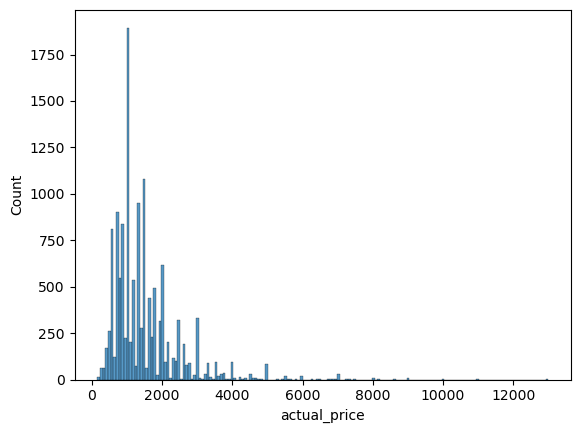

In [ ]:
sns.histplot(data_train['actual_price'])

<Axes: xlabel='actual_price', ylabel='Count'>

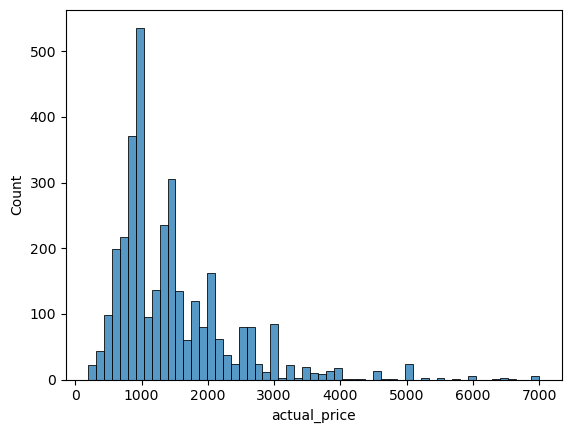

In [ ]:
sns.histplot(y_test)

In [ ]:
MachineLearning(X_train, y_train, X_test_mod, y_test_mod, features_selected)

Rodando modelo: XGBoost


Rodando modelo: SGD
Rodando modelo: LGBM
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 13484, number of used features: 7
[LightGBM] [Info] Start training from score 7.144035
Rodando modelo: DecisionTree
Rodando modelo: KNN
Rodando modelo: Bagging
Rodando modelo: RandomForest


,SMAPE
XGBoost,41.740091
SGD,41.945403
LGBM,41.959996
DecisionTree,45.034237
KNN,46.028108
Bagging,43.737931
RandomForest,43.389711


# Fine Tuning

In [ ]:
best_model = XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=3).fit(X_train[features_selected], y_train)

## Submission

### Carregar os dados

In [ ]:
# Opening JSON file
sub = open('dataset/raw/test.json')
 
# returns JSON object as 
# a dictionary
data_sub_aux = json.load(sub)

data_sub = pd.json_normalize(data_sub_aux, record_path = 'data')
data_sub.columns = data_sub_aux['columns']
data_sub.head()

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title
0,35d28961-170f-515d-90d4-55ee978a8afa,4.8,40,Mo,Clothing and Accessories,2021-02-10 21:18:47,Accentuate your formal wardrobe by buying this...,['https://rukminim1.flixcart.com/image/128/128...,False,17,SHTFDYZGEXPED7YS,"[{'Pack of': '1'}, {'Model Name': 'Mods Slim f...",KKSONS,Topwear,32,Men Slim Fit Printed Button Down Collar Casual...
1,5089618f-7eec-571b-84b6-41c3b43a2ed4,3.7,31,True Bl,Clothing and Accessories,2021-02-10 22:12:20,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,10,TROFM47EVWRYK7ZU,"[{'Fit': 'Slim Fit'}, {'Occasion': 'Casual'}, ...",KAPSONSRETAILPVTLTD,Bottomwear,318,Slim Fit Men Brown Cotton Blend Trousers
2,84716375-2ea3-5376-bca1-ecef76b0aa87,3.2,26,vims rai,Clothing and Accessories,2021-02-11 01:16:36,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,8,FABFZAMPGDW3BKGX,"[{'Type': 'Shirt Fabric'}, {'Sales Package': '...",WHITE SKY,Fabrics,411,Rayon Printed Shirt Fabric (Unstitched)
3,84120873-2b67-5f2c-9074-803e52e278f7,3.6,30,True Bl,Clothing and Accessories,2021-02-10 22:21:32,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,10,BZRFNMGPNBQTYHMG,"[{'Color': 'Blue'}, {'Fabric': 'Polyester'}, {...",KAPSONSRETAILPVTLTD,"Blazers, Waistcoats and Suits",431,Solid Single Breasted Formal Men Full Sleeve B...
4,96238f84-3bb8-5ec1-b2f4-fe481ba35faa,2.5,21,ECKO Unl,Clothing and Accessories,2021-02-10 22:32:00,ECKO Unltd YD CHECK Cotton Woven Slim Fit IND...,['https://rukminim1.flixcart.com/image/128/128...,False,5,SHTFV5G6PZDQZEVZ,"[{'Pack of': '1'}, {'Style Code': 'EKSH001497'...",SandSMarketing,Topwear,512,Men Slim Fit Checkered Cut Away Collar Casual ...


### Transformar os dados

In [ ]:
def limpeza (df):
    df = df.drop(columns=['_id', 'pid','description', 'images'])
    # transformando de string para data
    df['crawled_at'] = pd.to_datetime(df['crawled_at']).dt.date

    return df

def feature_engen(df):
    ## out_of_stock - transformar para int 
    df['out_of_stock'] = df['out_of_stock'].astype('int64')

    # brand - substituir por outros
    df['brand'] = df['brand'].apply(lambda x: x.lower())

    # criando feature product
    df['product'] = df[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)
    
    return df

def submission_preparation(df, features_selected):
    
    df = limpeza(df)
    df = feature_engen(df)
    df = rescalling(df)
    df = transform(df)
    
    return df[features_selected]

### Aplicar sobre os dados de teste

In [ ]:
data_sub_mod = submission_preparation(data_sub, features_selected)

In [ ]:
y_hat = np.expm1(best_model.predict(data_sub_mod))

In [ ]:
df_submission = pd.DataFrame()
df_submission['pid'] = data_sub['pid']
df_submission['actual_price'] = y_hat

In [ ]:
df_submission.to_csv('submissions/submission_1.csv', index=False)

In [ ]:
data_sub_mod = submission_preparation(data_sub, features_selected)

In [ ]:
y_hat = np.expm1(best_model.predict(data_sub_mod))

In [ ]:
df_submission = pd.DataFrame()
df_submission['pid'] = data_sub['pid']
df_submission['actual_price'] = y_hat

In [ ]:
df_submission.to_csv('submissions/submission_1.csv', index=False)

------
# 10 Help Functions

In [ ]:
def f(x):
    try:
        return ast.literal_eval(str(x))   
    except Exception as e:
        print(e)
        return []

In [ ]:
def junta_dict(dict_list):
    dicionario = {}
    for d in dict_list:
        for key, value in d.items():
            dicionario[key] = value
    return dicionario

In [ ]:
def feature_engen(df):
    ## out_of_stock - transformar para int 
    df['out_of_stock'] = df['out_of_stock'].astype('int64')

    # brand - substituir por outros
    df['brand'] = df['brand'].apply(lambda x: x.lower())

    # criando feature product
    df['product'] = df[['category', 'sub_category']].apply(lambda x: x['category'] + '_' + x['sub_category'], axis = 1)
    
    ## Tratando variaveis respostas nulas
    prices = df[['seller','pid', 'actual_price']].groupby('pid').max().reset_index()
    precos_nulos = df.loc[df['actual_price'].isna(), ['_id','pid']]
    precos_recuperados = pd.merge(precos_nulos, prices, how = 'inner', on = 'pid')
    
    df_aux = pd.merge(df, precos_recuperados[['_id', 'actual_price']], on = '_id', how = 'left')
    df['actual_price'] = df_aux['actual_price_x'].fillna(0) + df_aux['actual_price_y'].fillna(0)
    
    df = df.dropna(subset=['actual_price'])
    
    return df

In [ ]:
def pipeline (df):
    df = limpeza(df)
    df = feature_engen(df)
    
    product_details = df['product_details'].apply(lambda x: f(x))
    product_details = pd.DataFrame([junta_dict(row) for row in product_details])
    
    return df, product_details


In [ ]:
def test_preparation(df):
    X_test = rescalling(X_test)
    X_test = transform(X_test)
    y_test = log_var_resposta(y_test)
    
    return X_test